# Imports

In [1]:
import numpy as np
from dataclasses import field

import matplotlib.pyplot as plt
from __future__ import annotations
import time

# Data models

## SCAPE_simulation class

In [2]:
class SCAPE_simulation:
    ''' 
    This class executes adaptive SCAPE protocol simulation
    '''
    # SCAPE simulation parameters
    N: int
    M: int
    s_min: int
    s_max: int
    k_init: int

    t_max: float
    delta_t: float
    n_ts: int

    # gamma function attrubutes
    a: float
    b: float
    fs: float
    f: float
    phi: float

    # arrays that are universal for a run
    timestamps: np.ndarray        # array of timestamp numbers
    gammas: np.ndarray            # array of gamma values for each timestamp
    true_pauli: np.ndarray      # array pauli parameters for each timestamp, shape: (4, n_ts)
    epsilons: np.ndarray          # array of BSC error rates (eps_x, eps_y, eps_z, 1) for each timestamp, shape: (4, n_ts)

    # array that are universal for an event
    flips_x: np.ndarray                # bit flips for every timestamp generated according to BSC error rates of basis X
    flips_y: np.ndarray                # bit flips for every timestamp generated according to BSC error rates of basis Y
    flips_z: np.ndarray                # bit flips for every timestamp generated according to BSC error rates of basis Z

    def __init__(self, N, M, s_min, s_max, k_init, t_max, a, b, fs, f, phi):
        self.N = N
        self.M = M
        self.s_min = s_min
        self.s_max = s_max
        self.k_init = k_init
        self.t_max = t_max
        self.a = a
        self.b = b
        self.fs = fs
        self.f = f
        self.phi = phi

        self.delta_t = 1 / self.fs
        self.n_ts = int(self.fs * self.t_max)

        self.set_arrays()
        
    # set arrays that are universal for runs
    def set_arrays(self):
        self.set_timestamps()
        self.set_gammas()
        self.set_true_pauli()
        self.set_epsilons()

    def set_timestamps(self):
        self.timestamps = np.arange(0, self.n_ts)

    def set_gammas(self):
        self.gammas = self.b + self.a * np.sin(2 * np.pi * self.f * self.delta_t * self.timestamps + self.phi)

    def set_true_pauli(self):
        one = np.ones_like(self.gammas)
        G = 0.25 * np.stack([
            np.stack([one, self.gammas, self.gammas**2, self.gammas**3], axis=-1),
            np.stack([self.gammas, one, self.gammas, self.gammas**2],    axis=-1),
            np.stack([self.gammas**2, self.gammas, one, self.gammas],    axis=-1),
            np.stack([self.gammas**3, self.gammas**2, self.gammas, one], axis=-1),
        ], axis=-2)  # shape (N,4,4)
        self.true_pauli = np.flip(np.linalg.eigvalsh(G), axis=1)  # (N,4): [pI,pX,pY,pZ]
    
        # numeric hygiene
        if np.any(self.true_pauli < -1e-7):
            raise ValueError("Pauli parameters contain negative values.")
        # set small negative values to 0
        self.true_pauli = np.clip(self.true_pauli, 0.0, None)
        self.true_pauli /= self.true_pauli.sum(axis=1, keepdims=True)

    def set_epsilons(self):
        EFPE_matrix = np.array(
            [[0, 0, 1, 1],
            [0, 1, 0, 1],
            [0, 1, 1, 0],
            [1, 1, 1, 1]]    
        )
        self.epsilons = np.dot(EFPE_matrix, self.true_pauli.T)




    
    def set_flips(self):
        self.flips_x = self.epsilons[0,:] > np.random.random(self.n_ts)
        self.flips_y = self.epsilons[1,:] > np.random.random(self.n_ts)
        self.flips_z = self.epsilons[2,:] > np.random.random(self.n_ts)
    
    def run(self, seed = 42, start_ts = None):
        '''
        Executes M simulations and return estimated Pauli parameters for every window
        '''
        np.random.seed(seed)
        
        est_timestamps = []
        est_pauli = []
        
        for _ in range(self.M):
            self.set_flips()
            est_step = EstimationStep(self, start_ts=start_ts)
            while True:       # loop over time windows
                res = est_step.run()
                if res is None:
                    break
                est_timestamps.append(res[0])
                est_pauli.append(res[1])
        if (len(est_timestamps) == 0):
            raise Exception('est_timestamps is empty')
        assert len(est_timestamps) == len(est_pauli), 'length of timestamps and pauli arrays do not match'

        est_timestamps = np.array(est_timestamps)
        est_pauli = np.array(est_pauli)
        return est_timestamps, est_pauli


## EstimationStep class

In [3]:
class EstimationStep:
    '''
    This class performs pauli parameters estimation for a windows with size N
    '''
    start_ts: int              # starting timestamp of the step
    
    k_x: int                   # repetition code for X basis
    k_y: int                   # repetition code for Y basis
    k_z: int                   # repetition code for Z basis

    sim: SCAPE_simulation      # SCAPE_simulation reference to get simulation parameters and universal arrays

    n_pairs: int               # 
    pair_len: int              # 
    channel_uses: int          # amount channels uses in a current step

    idx_x: np.ndarray          # the indeces X basis of this step uses
    idx_y: np.ndarray          # the indeces Y basis of this step uses
    idx_z: np.ndarray          # the indeces Z basis of this step uses
    
    step_flips_x: np.ndarray   # flips that X basis uses
    step_flips_y: np.ndarray   # flips that Y basis uses
    step_flips_z: np.ndarray   # flips that Z basis uses

    cri_x: np.ndarray          # CRI of codewords of X basis
    cri_y: np.ndarray          # CRI of codewords of Y basis
    cri_z: np.ndarray          # CRI of codewords of Z basis    

    eps_hat: np.ndarray        # estimated BSC error rates
    pauli_hat: np.ndarray      # estimated Pauli parameters
    
    def __init__(self, scape_sim, start_ts = None):        
        self.sim = scape_sim
        if start_ts is None:
            self.start_ts = np.random.randint(0, self.sim.N - 1)
        else:
            self.start_ts = start_ts

        self.k_x = self.k_y = self.k_z = self.sim.k_init

    def run(self):
        if not self.has_enough_timestamps():
            return None

        if self.count_pairs() is None:
            return None
        self.set_channel_uses()
        self.set_indices()
        self.compute_cri()
        self.compute_eps()
        self.compute_pauli_hats()

        self.update_k()
        self.start_ts += self.channel_uses

        return (self.start_ts, self.pauli_hat)
        
    def has_enough_timestamps(self):
        if self.sim.n_ts - self.start_ts < self.sim.N:
            return False
        else:
            return True
    def count_pairs(self):
        self.n_pairs = int(self.sim.N / (self.k_x + self.k_y + self.k_z))
        if (self.n_pairs == 0):
            return None
        self.pair_len = self.k_x + self.k_y + self.k_z
        return 1

    def set_channel_uses(self):
        self.channel_uses = self.n_pairs * self.pair_len

    def set_indices(self):
        pattern = np.array(['X'] * self.k_x + ['Y'] * self.k_y + ['Z'] * self.k_z)
        labels = np.tile(pattern, self.n_pairs)

        idx = np.arange(self.start_ts, self.start_ts + self.channel_uses)
        self.idx_x = idx[labels == 'X']
        self.idx_y = idx[labels == 'Y']
        self.idx_z = idx[labels == 'Z']

        self.step_flips_x = self.sim.flips_x[self.idx_x]
        self.step_flips_y = self.sim.flips_y[self.idx_y]
        self.step_flips_z = self.sim.flips_z[self.idx_z]

        if (len(self.step_flips_x) == 0):
            raise Exception('self.step_flips_x is empty!')

    def compute_cri(self):
        ones_x = self._block_sums(self.step_flips_x, self.k_x)
        ones_y = self._block_sums(self.step_flips_y, self.k_y)
        ones_z = self._block_sums(self.step_flips_z, self.k_z)

        self.cri_x = self._cri(ones_x, self.k_x)
        self.cri_y = self._cri(ones_y, self.k_y)
        self.cri_z = self._cri(ones_z, self.k_z)

    @staticmethod
    def _block_sums(arr, k):
        n = len(arr)
        n_blocks = n // k
        return arr.reshape(-1, k).sum(axis=1)
    @staticmethod    
    def _cri(ones, k):
        return np.abs(k - 2 * ones) - (k - 1) / 2


    def compute_eps(self):
        
        if np.isnan(self.step_flips_x).any():
            raise Exception('nan value in self.step_flips_x')
        if np.isnan(self.step_flips_y).any():
            raise Exception('nan value in self.step_flips_y')
        if np.isnan(self.step_flips_z).any():
            raise Exception('nan value in self.step_flips_z')
        if len(self.step_flips_x) == 0 or len(self.step_flips_x) == 0 or len(self.step_flips_x) == 0:
            raise Exception('some of the flip arrays are empty')
        
        eps_x = np.sum(self.step_flips_x) / len(self.step_flips_x)
        eps_y = np.sum(self.step_flips_y) / len(self.step_flips_y)
        eps_z = np.sum(self.step_flips_z) / len(self.step_flips_z)

        self.eps_hat = np.array([eps_x, eps_y, eps_z, 1.])

    def compute_pauli_hats(self):
        conv_matrix = np.array(
            [[-0.5, -0.5, -0.5, 1], 
             [-0.5, 0.5, 0.5, 0], 
             [0.5, -0.5, 0.5, 0], 
             [0.5, 0.5, -0.5, 0]])
        self.pauli_hat = np.dot(conv_matrix, self.eps_hat)
    
    
    def update_k(self):
        self.k_x += self._cri_count(self.cri_x)
        self.k_y += self._cri_count(self.cri_y)
        self.k_z += self._cri_count(self.cri_z)

    def _cri_count(self, cri_arr):
        bigger = np.sum(cri_arr > self.sim.s_max)
        lower = np.sum(cri_arr < self.sim.s_min)
        if lower > 0:
            return 1
        elif bigger > 0.9 * len(cri_arr):
            return -1
        else:
            return 0

# Plots

In [4]:
def plot_hist(x, y, label, linecolor,linestyle = None, errorcolor=None,  nbins = 60):
    idx = np.argsort(x)
    x, y = x[idx], y[idx]

    xmin = x.min()
    xmax = x.max()

    edges = np.linspace(xmin, xmax, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    bin_ids = np.digitize(x, edges) - 1
    bin_ids = np.clip(bin_ids, 0, nbins - 1)
    
    means = np.array([y[bin_ids==b].mean() if (bin_ids==b).any() else np.nan 
                      for b in range(nbins)])
    stds  = np.array([y[bin_ids==b].std(ddof=1) if (bin_ids==b).size>1 else np.nan 
                      for b in range(nbins)])
 
    plt.plot(centers, means, linecolor+linestyle, label=label)
    plt.fill_between(centers, means-stds, means+stds, color=errorcolor, alpha=0.3)

In [22]:
def draw_pauli(time_points, est_pauli, N_val):
    # Plot true Pauli parameters
    plt.plot(sim.timestamps * sim.delta_t, sim.true_pauli[:,0], 'b', label=r'p_I')
    plt.plot(sim.timestamps * sim.delta_t, sim.true_pauli[:,1], 'red', label=r'p_X')
    plt.plot(sim.timestamps * sim.delta_t, sim.true_pauli[:,2], 'green', label=r'p_Y')
    plt.plot(sim.timestamps * sim.delta_t, sim.true_pauli[:,3], 'black', label=r'p_Z')
    
    # Plot estimated Pauli parameters
    plot_hist(time_points, est_pauli[:,0], label=r'$\hat{p}_I$', linecolor='b', linestyle='--', errorcolor='grey')
    plot_hist(time_points, est_pauli[:,1], label=r'$\hat{p}_X$', linecolor='r', linestyle='--', errorcolor='grey')
    plot_hist(time_points, est_pauli[:,2], label=r'$\hat{p}_Y$', linecolor='g', linestyle='--', errorcolor='grey')
    plot_hist(time_points, est_pauli[:,3], label=r'$\hat{p}_Z$', linecolor='k', linestyle='--', errorcolor='grey')
    
    plt.ylim(0,1)
    plt.yticks(np.arange(0,1.01,0.25))
    
    plt.xlim(0,2.)
    plt.xticks(np.arange(0,2.01,0.2))
    plt.grid(axis="y", linestyle="--")
    plt.grid(axis="x", linestyle="--")

    plt.xlabel("Time t [seconds]")                 
    plt.ylabel("Pauli parameters")
    
    plt.legend()
    plt.savefig("N_" + str(N_val) + ".png", dpi=300, bbox_inches="tight")
    plt.show()

In [6]:
def plot_N_dependence(N_array, diamonds_mean, diamonds_std, norm):
    plt.plot(N_array, np.array(diamonds_mean[0]), label='f = 0.6')
    plt.plot(N_array, np.array(diamonds_mean[1]), label='f = 0.8')
    plt.plot(N_array, np.array(diamonds_mean[2]), label='f = 1.0')
    
    plt.fill_between(N_array, np.array(diamonds_mean[0])-np.array(diamonds_std[0]), np.array(diamonds_mean[0])+np.array(diamonds_std[0]), alpha=0.3)
    plt.fill_between(N_array, np.array(diamonds_mean[1])-np.array(diamonds_std[1]), np.array(diamonds_mean[1])+np.array(diamonds_std[1]), alpha=0.3)
    plt.fill_between(N_array, np.array(diamonds_mean[2])-np.array(diamonds_std[2]), np.array(diamonds_mean[2])+np.array(diamonds_std[2]), alpha=0.3)
    
    plt.xlabel("Number of Samples N")              
    plt.ylabel(r"$\|\mathcal{N} - \hat{\mathcal{N}}_N\|_{\diamond}$")
    
    plt.xlim(150, 1500)        
    plt.xticks([150, 300, 600, 900, 1200, 1500])  

    plt.title(norm + " norm dependence on N")
    plt.legend()
    if norm == 'RMSE':
        plt.savefig("rmse_vs_window.png", dpi=300, bbox_inches="tight")
    plt.show()

# Norms calculation

In [7]:
def get_diamond_norm(p, p_hat):
    return np.sum(np.abs(p - p_hat))

In [8]:
def get_rmse(p, p_hat):
    return np.sqrt(np.mean((p - p_hat) ** 2))

In [9]:
def calculate_mean_std_of_norms(timestamps, est_pauli, norm_function):
    idx = np.argsort(timestamps)
    timestamps, est_pauli = timestamps[idx], est_pauli[idx]

    diamond_norms = []
    for i in range(len(timestamps)):
        true_p = sim.true_pauli[timestamps[i]]
        est_p = est_pauli[i, :]
        diamond_norms.append(norm_function(true_p, est_p))
    return np.mean(diamond_norms), np.std(diamond_norms)



# Configuration

In [10]:
N = 1000
M = 1000
s_min = 1
s_max = 3
k_init = 5
t_max = 2.
a = 0.3
b = 0.7
fs = 10000
f = 1.
phi = np.pi / 2

# Estimated Pauli vs True Pauli

In [26]:
N = 1000
seed = 42

start_sim_time = time.time()

sim = SCAPE_simulation(N, M, s_min, s_max, k_init, t_max, a, b, fs, f, phi)
est_timestamps, est_pauli = sim.run(seed)

end_sim_time = time.time()
print('simulation time:', (end_sim_time - start_sim_time), 'sec')
time_points = est_timestamps * sim.delta_t

simulation time: 0.21808648109436035 sec


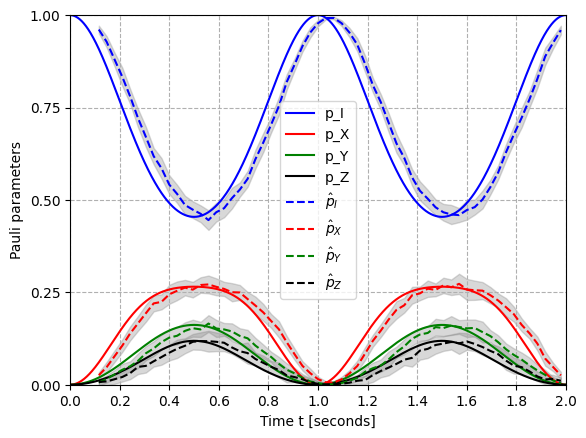

In [27]:
draw_pauli(time_points, est_pauli, N)

In [28]:
N = 500
seed = 42

start_sim_time = time.time()

sim = SCAPE_simulation(N, M, s_min, s_max, k_init, t_max, a, b, fs, f, phi)
est_timestamps, est_pauli = sim.run(seed)

end_sim_time = time.time()
print('simulation time:', (end_sim_time - start_sim_time), 'sec')
time_points = est_timestamps * sim.delta_t

simulation time: 0.3595144748687744 sec


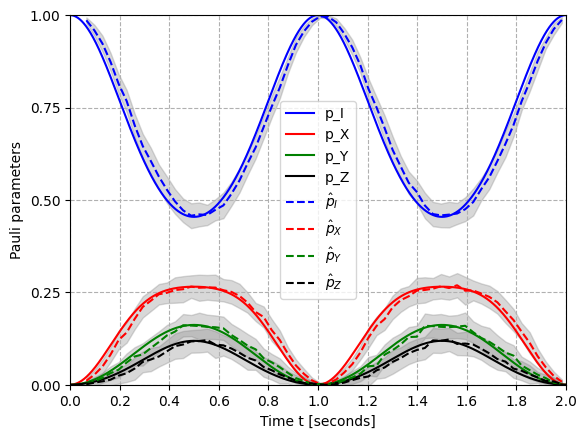

In [29]:
draw_pauli(time_points, est_pauli, N)


In [30]:
N = 350
seed = 42

start_sim_time = time.time()

sim = SCAPE_simulation(N, M, s_min, s_max, k_init, t_max, a, b, fs, f, phi)
est_timestamps, est_pauli = sim.run(seed)

end_sim_time = time.time()
print('simulation time:', (end_sim_time - start_sim_time), 'sec')
time_points = est_timestamps * sim.delta_t

simulation time: 0.5094285011291504 sec


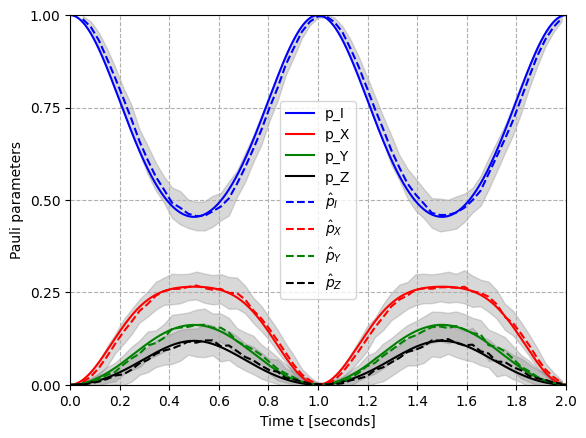

In [31]:
draw_pauli(time_points, est_pauli, N)


# Compare N (window sizes)

In [17]:
M = 100

N_array = np.arange(150, 1501, 400)
f_array = [0.6, 0.8, 1]

all_diamonds_means = []
all_diamonds_stds = []

all_rmse_means = []
all_rmse_stds = []

for f_i in f_array:
    d_means = []
    d_stds = []

    rmse_means = []
    rmse_stds = []
    
    for N_i in N_array:
        start_sim_time = time.time()
        sim = SCAPE_simulation(N_i, M, s_min, s_max, k_init, t_max, a, b, fs, f_i, phi)
        est_timestamps, est_pauli = sim.run(start_ts=0)
        end_sim_time = time.time()
        print('simulation time:', (end_sim_time - start_sim_time), 'sec')
        time_points = est_timestamps * sim.delta_t

        mean_d, std_d = calculate_mean_std_of_norms(est_timestamps, est_pauli, get_diamond_norm)
        mean_rmse, std_rmse = calculate_mean_std_of_norms(est_timestamps, est_pauli, get_rmse)
        
        d_means.append(mean_d)
        d_stds.append(std_d)

        rmse_means.append(mean_rmse)
        rmse_stds.append(std_rmse)
        
    all_diamonds_means.append(d_means)
    all_diamonds_stds.append(d_stds)

    all_rmse_means.append(rmse_means)
    all_rmse_stds.append(rmse_stds)

simulation time: 0.5994396209716797 sec
simulation time: 0.33782196044921875 sec
simulation time: 0.2190253734588623 sec
simulation time: 0.167860746383667 sec
simulation time: 0.9440476894378662 sec
simulation time: 0.3212282657623291 sec
simulation time: 0.21804356575012207 sec
simulation time: 0.1647508144378662 sec
simulation time: 1.1907269954681396 sec
simulation time: 0.33534955978393555 sec
simulation time: 0.224822998046875 sec
simulation time: 0.16118717193603516 sec


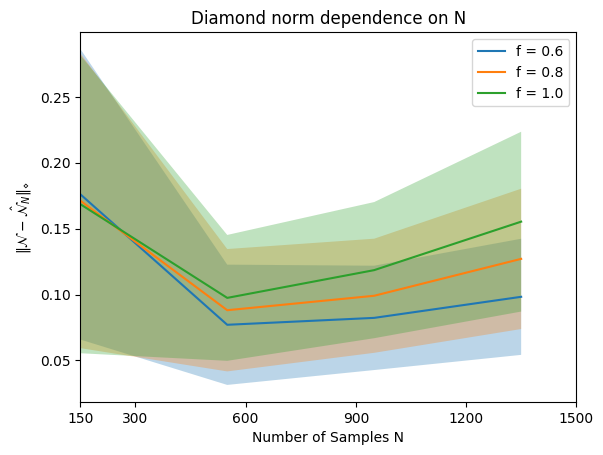

In [18]:
plot_N_dependence(N_array, all_diamonds_means, all_diamonds_stds, norm = 'Diamond')

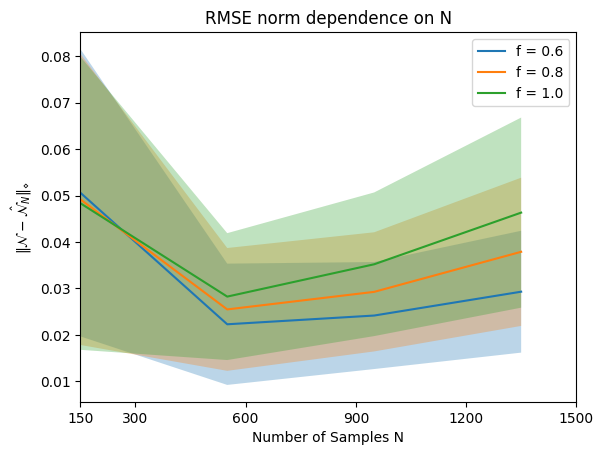

In [19]:
plot_N_dependence(N_array, all_rmse_means, all_rmse_stds, norm = 'RMSE')